In [1]:
%load_ext autoreload
%autoreload 2

#%%timeit
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
import sys
import copy
import time 
import argparse

from pathlib import Path
#from symbolicregression.envs.generators import RandomRecurrence
#from symbolicregression.envs.encoders import Equation, IntegerSeries, RealSeries
from sympy import *
import pickle
from collections import defaultdict, OrderedDict
import math
import pandas as pd

import symbolicregression
from symbolicregression.envs import ENVS, build_env
from symbolicregression.model import build_modules
from symbolicregression.envs.generators import RandomFunctions
from symbolicregression.envs.encoders import  Equation, FloatSequences
from symbolicregression.envs.environment import FunctionEnvironment
#from notebook_utils import pad_input, process_inputs
from IPython.display import display
from symbolicregression.model.embedders import *
from symbolicregression.trainer import Trainer
from evaluate import Evaluator
from symbolicregression.utils import bool_flag, initialize_exp

import warnings
warnings.filterwarnings('ignore')

#python train.py --eval_size 10 --n_inner_epochs 10 --collate_queue_size 10


# Playing with generator

## Generator statistics

In [76]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.debug = True
args.max_dimension = 3
    
env = FunctionEnvironment(args)

env.rng = np.random.RandomState()
#env.gen_expr(train=False)

for i in range(10):
    tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=2)
    tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
    print('System :')
    for expr in tree_sympy:
        display(expr)

System :


-0.773*t - 0.221*x_0 + 1.99

3.43*t - 45.4*x_0 - 2.79 + 45.3/(-44.4*x_1 - 8.09)

System :


t**2*x_0*(-2.99*t - 64.5*x_0 + 63.6*cos(63.6*x_1 + 0.215)) - 0.525

x_1*(-1.34*t*x_0 - 75.5*t + 0.21*x_1 + 0.454*cos(6.22*t + 9.69)) + 0.127

System :


x_0*(7.73*x_1 + 45.4*cos(89.0*t + 0.388*x_1)) + 8.72

-2.3242*t*x_0*x_1 - 4.51*x_1 + 8.31

System :


(-77.2*x_0 + 33.1*x_1)*(-0.57*t - 0.278*x_0 + 184.5*x_1) + 7.29

-0.421*t*x_0 - 7.819*x_1 - 7.5*cos(0.791*t + 2.9) - 0.019

System :


2.29*x_0*x_1 + 8.73

x_0*(-27.5*x_0 - 0.407*x_1) + 7.3

System :


-18.3*t - 68.7*x_0 + 0.077*x_1 - 0.988*sin(0.448*x_1 - 0.15) - 0.007

0.78*t - 100.7624*x_0*x_1 + 9.09*x_0 - 89.9*x_1 - 0.49

System :


-0.518*x_0 - 0.09*x_1*(-40.1*t + 0.616*x_0) - 0.645*x_1 - 0.807

(-99.5*t - 41.9*x_1)*(-4.16*x_0 - 0.39*x_1*(79.4*t + 0.52*x_0)) + 0.106

System :


x_1*cos(8.14*x_0 + 0.925) - 6.07

0.228*x_0 + 0.843

System :


0.094*x_0 - 1.9*x_1 + 1.72*cos(0.762*t + 79.8) - 4.52

1.7*x_0 - 1.06 - 0.373/(59.7 - 6.03*x_1)

System :


-89.62*x_0*x_1 + 3.96

-3.67*t - 6.51

System :


-0.776*t - 7.99*x_2**2*(12.2*x_0 - 0.327*x_1 + 0.831*x_2) + 8.39

x_2*(83.3*x_0 - 0.012*x_1 + 95.7*x_2) - 3.0

-7.05*x_0*sin(53.1*x_1 - 6.37) - 0.991*x_0 - 37.1*x_2 - 74.3

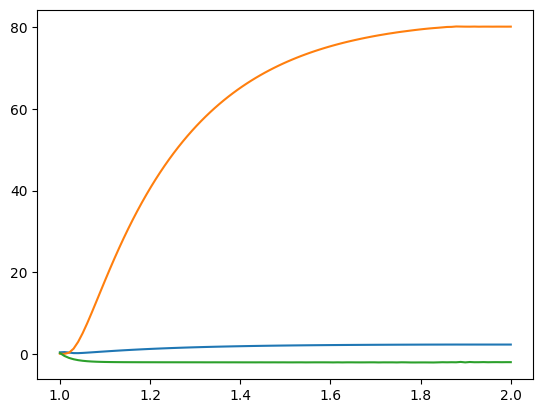

In [85]:
from scipy.integrate import odeint
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=3)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = np.linspace(1,2,100)
def func(y,t):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        sol = odeint(func, y0, t)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

for dim in range(dimension):
    plt.plot(t,sol[:,dim])


System :


x_1*(-0.179*t - 58.37*x_0 + 0.407*x_1 - 7.31*sin(91.0*x_0 + 57.2)) + 3.95

14.8*t + 0.573*x_0*(0.543*x_0 + 28.0*x_1 - 0.933*x_1/(0.482*x_1 - 8.42)) + 0.7

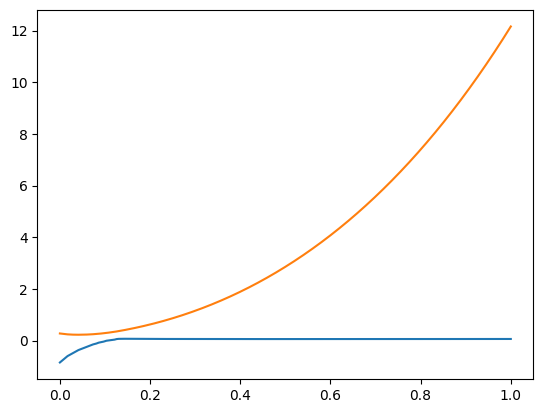

In [75]:
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=2)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = (0,1)
def func(t,y):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        #sol = odeint(func, y0, t)
        sol = solve_ivp(func, t, y0)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

t = sol.t
sol = sol.y.T
for dim in range(dimension):
    plt.plot(t,sol[:,dim])


In [2]:
runs = []
logs = []
global_path = '/scratch/dascoli/odeformer/experiments/'

paths = [
    #'dropout'
    #'int_base'
    #'precision'
    #"curriculum"
    "first"
       ]


NaN = np.nan
Infinity = np.nan

for path in paths:
    path = os.path.join(global_path, path)
    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        try : 
            run = {}
            args = pickle.load(open(dirname+'/params.pkl', 'rb'))
            run['args'] = args
            run['logs'] = []
            run['num_params'] = []
            logfile = dirname+'/train.log'
            f = open(logfile, "r")
            for line in f.readlines():
                if '__log__' in line:
                    log = eval(line[line.find('{'):].rstrip('\n'))
                    run['logs'].append(log)
                    #if not run['logs']: run['logs'].append(log)
                    #else: 
                    #    if log['valid1_recurrence_beam_acc'] != run['logs'][-1]['valid1_recurrence_beam_acc']: run['logs'].append(log)
            f.close()
            args.output_dir = Path(dirname)
            runs.append(run)
        except Exception as e: 
            print(e)
            print('failed !'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/scratch/dascoli/odeformer/experiments/first/
1 runs found
/scratch/dascoli/odeformer/experiments/first/exp_optimizer_adam_cosine,period_mult=1.5,lr_shrink=0.5
0 fails


In [5]:
run = runs[0]
params = run['args']
env = build_env(params)
modules = build_modules(env, params)
trainer = Trainer(modules, env, params)
evaluator = Evaluator(trainer)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4134914322155D+00   r2 =  0.2493340335951D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4134914322155D+00   r2 =  0.2493340335951D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4134914322155D+00   r2 =  0.2493340335951D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4134914322155D+00   r2 =  0.1287108106921D-16
 lsoda--  warning..internal t (=r1) 

Reloading checkpoint from /scratch/dascoli/odeformer/experiments/first/exp_optimizer_adam_cosine,period_mult=1.5,lr_shrink=0.5/checkpoint.pth ...
Reloading checkpoint optimizer ...


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.9307692307692D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.9304673231036D+00   r2 =  0.9304713404309D+00
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.9384615384615D+00
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.9304673231036D+00   r2 =  0.9304713404309D+00
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.9384615384615D+00


Checkpoint reloaded. Resuming at epoch 1 / iteration 1000 ...


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2371854855994D-01   r2 =  0.7595105673950D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2371854855994D-01   r2 =  0.7595105673950D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2371854855994D-01   r2 =  0.7595105673950D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2371854855994D-01   r2 =  0.6859838100046D-18
 lsoda--  warning..internal t (=r1) 

In [6]:
scores = evaluator.evaluate_in_domain(
    "valid1",
    "functions",
    logger=trainer.logger,
    save=params.save_results,
    ablation_to_keep=params.ablation_to_keep,
)
print("__log__:%s" % json.dumps(scores))


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6528133305160D-01   r2 =  0.4542485913152D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6528133305160D-01   r2 =  0.4542485913152D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6528133305160D-01   r2 =  0.4542485913152D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6528133305160D-01   r2 =  0.5679796476999D-17
 lsoda--  warning..internal t (=r1) 

AttributeError: 'Evaluator' object has no attribute 'valid1_env'

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9298258156577D-01   r2 =  0.6856860420737D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9298258156577D-01   r2 =  0.6856860420737D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9298258156577D-01   r2 =  0.6856860420737D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9298258156577D-01   r2 =  0.5635423237616D-17
 lsoda--  warning..internal t (=r1) 

In [8]:
    # training
    if params.reload_data != "":
        data_types = [
            "valid{}".format(i) for i in range(1, len(trainer.data_path["functions"]))
        ]
    else:
        data_types = ["valid1"]
    evaluator.set_env_copies(data_types)

    # evaluation
scores = evaluator.evaluate_in_domain(
    "valid1",
    "functions",
    logger=trainer.logger,
    save=params.save_results,
    ablation_to_keep=params.ablation_to_keep,
)
logger.info("__log__:%s" % json.dumps(scores))

  0%|          | 0/10000 [00:00<?, ?it/s]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1892613462739D-02   r2 =  0.4479347714478D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1892613462739D-02   r2 =  0.4479347714478D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1892613462739D-02   r2 =  0.4479347714478D-19
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1892613462739D-02   r2 =  0.6990593524222D-21
 lsoda--  warning..internal t (=r1) 

TypeError: 'int' object is not iterable